# GTrack

## Hand gestures detection, classification and tracking using Convolutional Neural Network on the example of the Russian Sign Language

The project demonstrates the system for detection, classification and tracking of static hand gestures of Russian Sign Language, which is based on the approach of computer vision using Convolutional Neural Network. The work is actual and represents a core pipeline for systems with gesture control and for researchers from gesture-related areas.

Author: Oleg Potkin

In [1]:
## Dependencies

# Setup visualisation format
%matplotlib inline
# Retina-display quality for figures
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import os           # operating system functions
import numpy as np  # matrix operations

# Computer vision functions
import cv2 
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

# Deep Learning components
import torch, torchvision
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler


## Check if CUDA is available
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

OpenCV Version: 3.4.2
CUDA is not available.  Training on CPU ...


# Helper functions

# Part 1: Data
## 1.1 Load data

In [2]:
# Directory with dataset
data_dir = 'gesture_set'

# Number of subprocesses to use for data loading
num_workers = 0
# How many samples per batch to load
batch_size = 10
# Percentage of training set to use as validation
valid_size = 0.25
# Learning rate for CNN
learning_rate = 0.01

In [3]:
# Define transforms for the training data and testing data
transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    #transforms.ColorJitter(hue=.05, saturation=.05),
    #transforms.RandomResizedCrop(250),
    transforms.Resize(64),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])
    #,transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

# Obtain training indices that will be used for validation
num_train = len(train_data)
print("Training set size = {0}".format(train_data))
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# Specify the image classes
classes = ['А', 'Б', 'В', 'Г', 'Е', 'И', 'О', 'П', 'С', 'Я']

Training set size = Dataset ImageFolder
    Number of datapoints: 1888
    Root Location: gesture_set/train
    Transforms (if any): Compose(
                             RandomRotation(degrees=(-7, 7), resample=False, expand=False)
                             Resize(size=64, interpolation=PIL.Image.BILINEAR)
                             Grayscale(num_output_channels=1)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [ ]:
# obtain one batch of training images
#dataiter = iter(train_loader)
#images, labels = dataiter.next()
#images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
#fig = plt.figure(figsize=(8, 8))
#columns = 7;
#rows = 5;
# display N images
#for idx in range(1, columns*rows+1):
#    ax = fig.add_subplot(rows, columns, idx, xticks=[], yticks=[])
#    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#    ax.set_title(classes[labels[idx]])

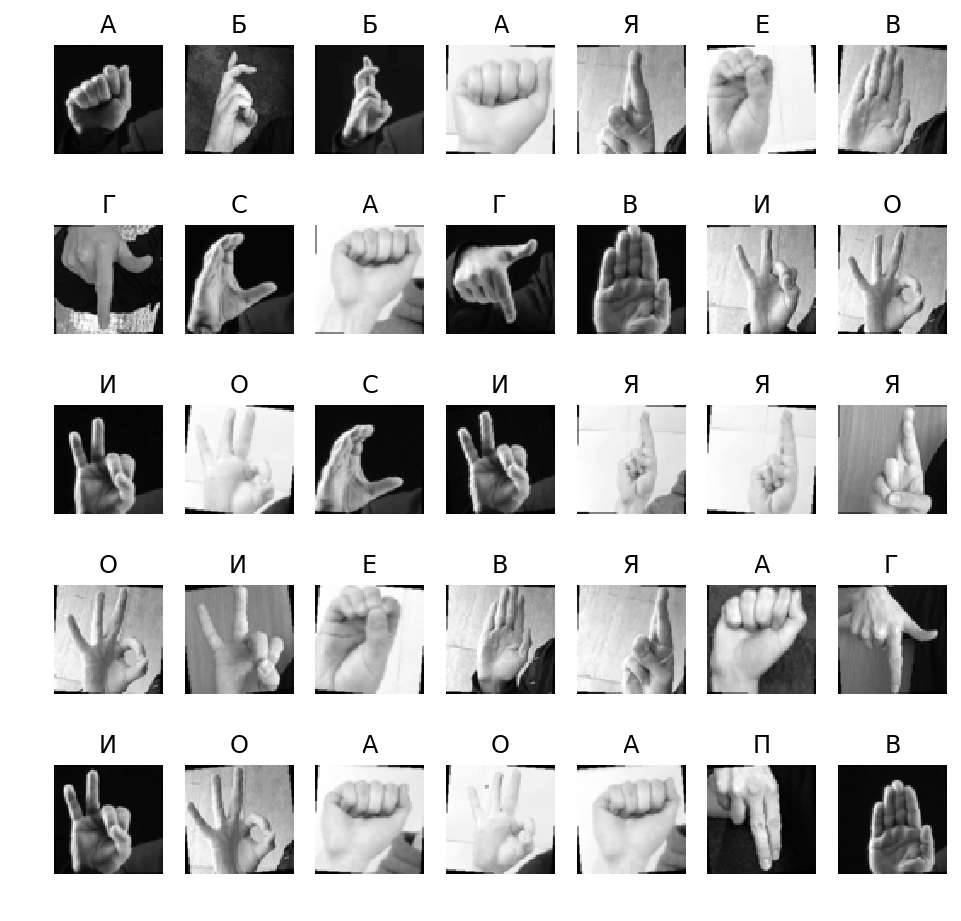

In [4]:
fig = plt.figure(figsize=(8,8));
columns = 7;
rows = 5;
for i in range(1, columns*rows+1):
    img_xy = np.random.randint(len(train_data));
    img = train_data[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(classes[train_data[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy()
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)).reshape(images[idx].shape[1],images[idx].shape[2]), cmap='gray')
    ax.set_title(classes[labels[idx]])

In [ ]:
# Obtain one batch of validation images
dataiter = iter(valid_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy()
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)).reshape(images[idx].shape[1],images[idx].shape[2]), cmap='gray')
    ax.set_title(classes[labels[idx]])

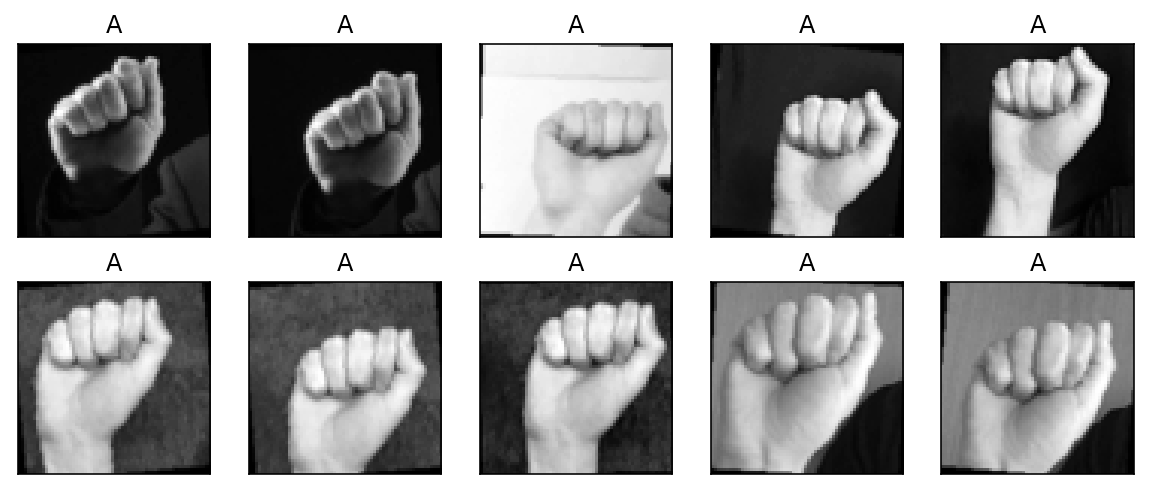

In [5]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy()
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(10, 4))
# display 10 images
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx],(1,2,0)).reshape(images[idx].shape[1],images[idx].shape[2]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Part 2: CNN Architecture

In [ ]:
## Only for testing

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.features = nn.Sequential(
            # Output = ((Width-Kernel + 2*Padding ) / Stride) + 1
            nn.Conv2d(1, 8, kernel_size=5, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(8, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(32, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            #10 - num_classes
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        #print(x.shape)
        x = x.view(x.size(0), 64 * 6 * 6)
        x = self.classifier(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [6]:
## Working use-case

import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        #initial#self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=2, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        #self.fc1 = nn.Linear(64 * 6 * 6, 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 1200)
        # linear layer (500 -> 200)
        self.fc2 = nn.Linear(1200, 500)
        # linear layer (500 -> 10)
        self.fc3 = nn.Linear(500, 10)
        # dropout layer (p=0.2)
        self.dropout = nn.Dropout(0.2)

        ## The 'forward' function is called on the Neural Network for a set of inputs,
        ## and it passes that input through the different layers that have been defined.
    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # flatten image input
        #print(x.shape)
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1200, bias=True)
  (fc2): Linear(in_features=1200, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


In [7]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);

In [ ]:
# number of epochs to train the model
n_epochs = 70

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_augmented.pt')
        valid_loss_min = valid_loss

###  Load the Model with the Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load('model_augmented.pt'))

## Part 3: Evaluation

In [13]:
from torch.autograd import Variable

model.eval()
correct = 0
total = 0
for data, target in test_loader:
    images = Variable(data.float())
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    total += target.size(0)
    correct += (predicted == target).sum()
print('Test Accuracy of the model on the XXX test images: %.4f %%' % (100 * correct / total))
print (correct)

Test Accuracy of the model on the XXX test images: 93.0000 %
tensor(150)


In [14]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
test_var = 0;
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.361992

Test Accuracy of     А: 100% (16/16)
Test Accuracy of     Б: 93% (15/16)
Test Accuracy of     В: 87% (14/16)
Test Accuracy of     Г: 87% (14/16)
Test Accuracy of     Е: 100% (16/16)
Test Accuracy of     И: 87% (14/16)
Test Accuracy of     О: 100% (16/16)
Test Accuracy of     П: 81% (13/16)
Test Accuracy of     С: 100% (16/16)
Test Accuracy of     Я: 93% (15/16)

Test Accuracy (Overall): 93% (149/160)


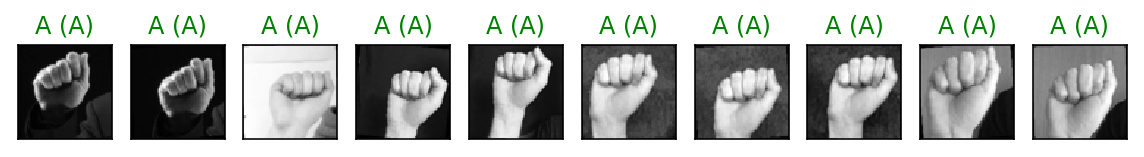

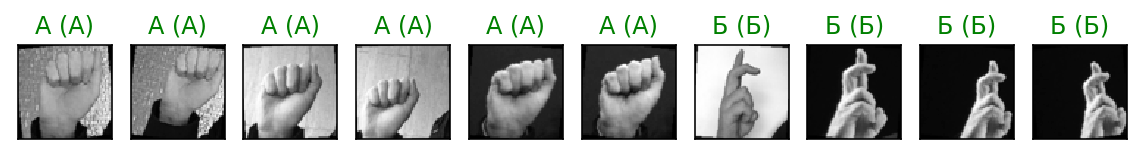

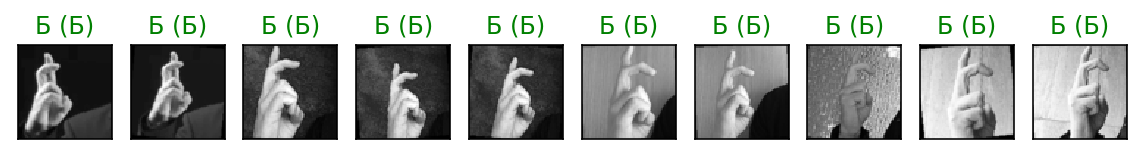

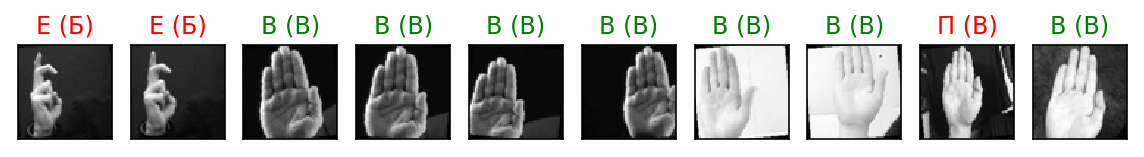

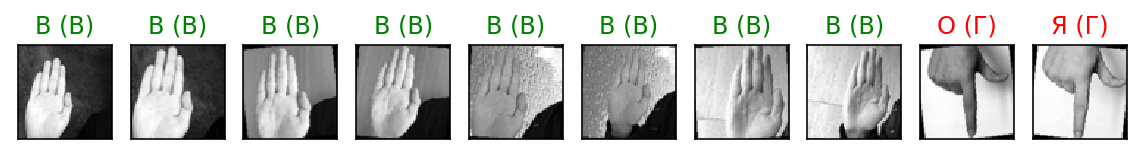

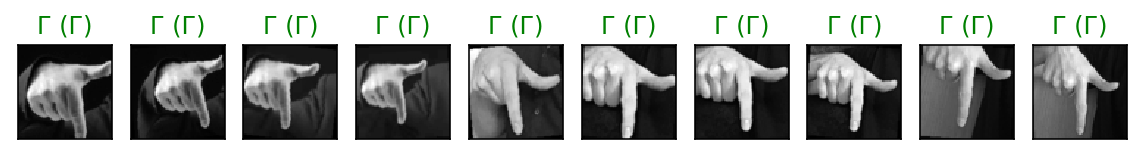

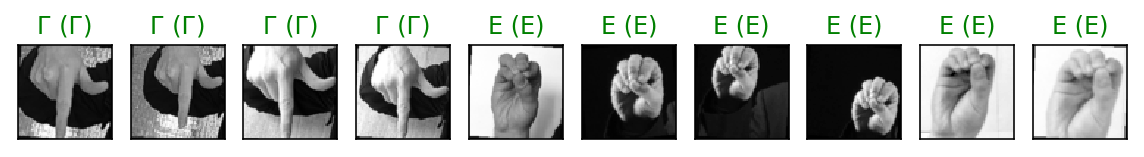

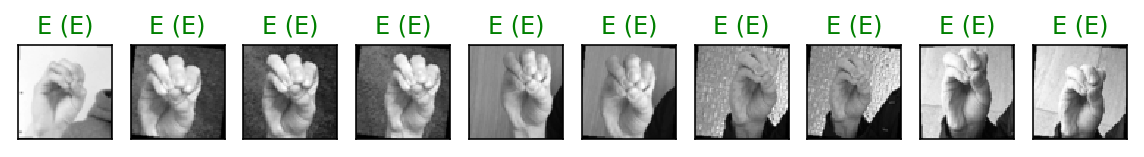

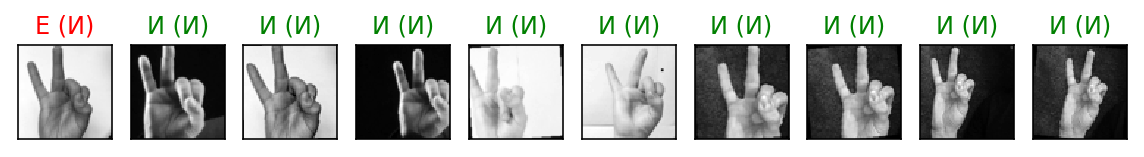

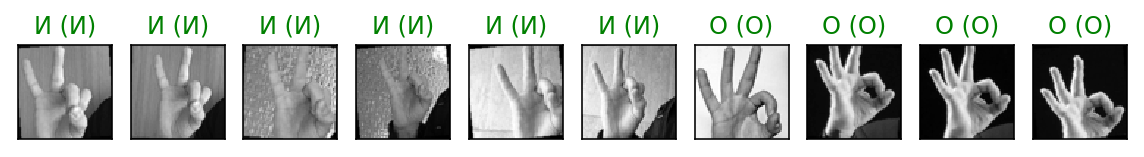

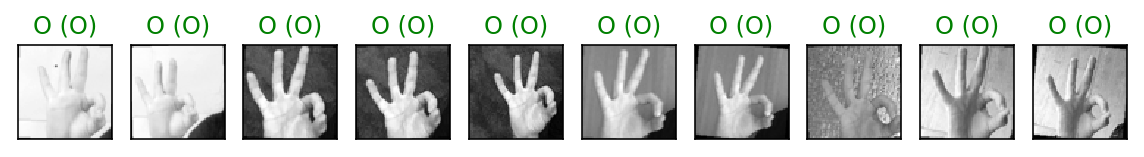

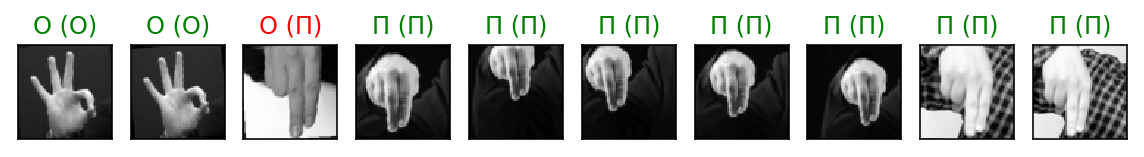

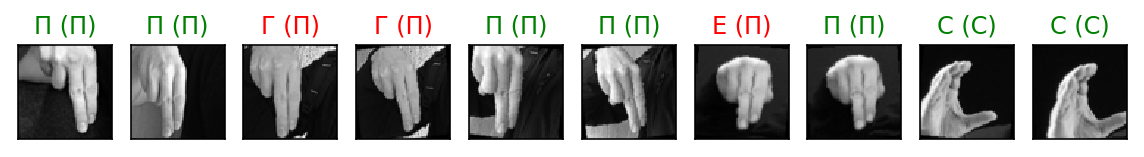

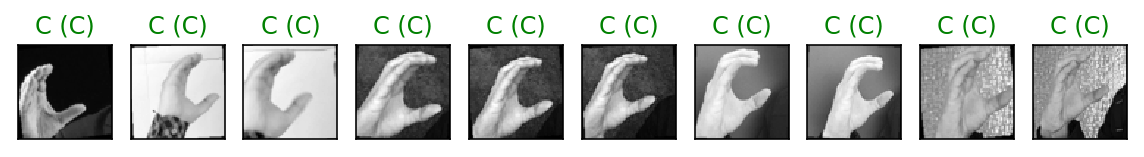

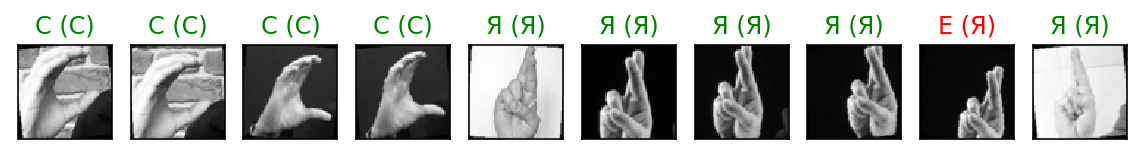

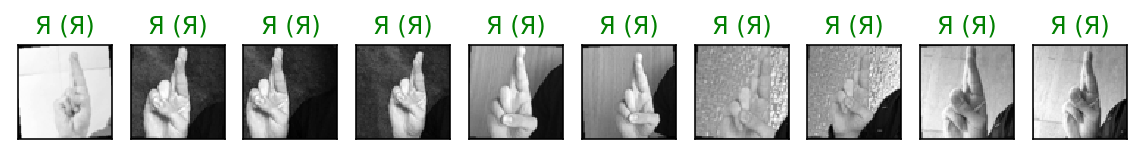

In [15]:
dataiter = iter(test_loader)
for i in range (16):
    # obtain one batch of test images
    images, labels = dataiter.next()
    images.numpy()

    # move model inputs to cuda, if GPU available
    if train_on_gpu:
        images = images.cuda()

    # get sample outputs
    output = model(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(16, 1))
    for idx in np.arange(10):
        ax = fig.add_subplot(1, 16, idx+1, xticks=[], yticks=[])
        #imshow(images[idx])
        plt.imshow(np.transpose(images[idx],(1,2,0)).reshape(images[idx].shape[1],images[idx].shape[2]), cmap='gray')
        ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                     color=("green" if preds[idx]==labels[idx].item() else "red"))

In [ ]:
from PIL import Image

def check_class(image):
    model.eval()
    
    image = Image.fromarray(image)
    image_pil = image
    #plt.imshow(image_pil)
    
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
    
    img = transform(image)
    
    img.unsqueeze_(0)

    # Predict classes using images from the test set
    output = model(img)
    _, prediction = torch.max(output, 1)
    preds = np.squeeze(prediction.cpu().numpy())
    #print(classes[preds])
    
    return classes[preds]

In [ ]:
def check_bounding_box(x, y, w, h):
    x = x - 10
        
    if (y < 10):
        y = 1 
    else:
        y = y - 10
    
    if w > h:
        h = w
    else:
        w = h
        x = x - 10
        
    return x, y, w, h

In [ ]:
def hand_filter(input_image):
    # Make a copy of input image
    image_proc   = input_image   # For processing / filtering
    image_result = input_image   # For result
    
    # Blur the image
    image_blur = cv2.blur(image_proc, (3,3))
    
    # Convert the image from RGB to HSV color space
    image_hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)
    
    # Define the upper and lower boundaries of the HSV pixel
    # intensities to be considered 'skin'
    skin_lower_bound  = np.array([120, 24, 80],   dtype = "uint8")
    skin_upper_bound  = np.array([200, 255, 255], dtype = "uint8")
    skin_mask_level_1 = cv2.inRange(image_hsv, skin_lower_bound, skin_upper_bound)
    
    # Apply a series of erosions and dilations to the mask
    # using an elliptical kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    skin_mask_level_2 = cv2.erode(skin_mask_level_1, kernel, iterations = 2)
    skin_mask_level_3 = cv2.dilate(skin_mask_level_2, kernel, iterations = 2)
    
    # Filter part of an image
    for i in range(400, 900):
        skin_mask_level_3[:,i] = 0
    
    # Detect and draw a hand rectangle (bounding box)
    active_px = np.argwhere(skin_mask_level_3 != 0)
    active_px = active_px[:, [1,0]]
    x, y, w, h = cv2.boundingRect(active_px)    # Detect bounding box
    x, y, w, h = check_bounding_box(x, y, w, h) # Resize bounding box
    
    # Save detected area
    roi = image_result[y:y+h+20, x:x+w+20]
    
    ## This line could be use to collect a dataset from the video stream
    # cv2.imwrite("ro{0}i{1}.jpg".format(h, w), roi)
    
    # Draw Bounding Box
    cv2.rectangle(image_result, (x, y), (x+w+20,y+h+20), (0,255,0), 2)
    
    #image_bup = cv2.cvtColor(image_bup, cv2.COLOR_BGR2RGB)
    #plt.imshow(image_bup)
    
    return image_result, roi, skin_mask_level_1, skin_mask_level_3, image_hsv

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def image_pipeline(image):
    # Step 1: preprocessing
    image, roi, skin_mask_init, skin_mask_final, image_hsv = hand_filter(image)
    # Step 2: classification
    class_name = check_class(roi)
    
    ### Add thumbnail 1 (HSV filter)
    thumb_width = 240
    thumb_height = 130
    x_offset1 = image.shape[1] - thumb_width - 20
    y_offset1 = 80
    #hsv_crop = image_hsv[y:y+h, x:x+w]
    hsv_crop = image_hsv[0:405, 100:100+645]
    hsv_bgr  = cv2.cvtColor(hsv_crop, cv2.COLOR_HSV2BGR)
    hsv_bgr_thumb = 255*cv2.resize(hsv_bgr, (thumb_width, thumb_height), interpolation=cv2.INTER_AREA)
    image.setflags(write=1) # Needed to modify image structure
    image[y_offset1:y_offset1 + hsv_bgr_thumb.shape[0], x_offset1:x_offset1 + hsv_bgr_thumb.shape[1]] = hsv_bgr_thumb
    ### Add thumbnail 2 (Binary filter)
    x_offset2 = image.shape[1] - thumb_width - 20
    y_offset2 = 80 + thumb_height + 30
    resized_bin = 255*cv2.resize(skin_mask_init, (thumb_width, thumb_height), interpolation=cv2.INTER_AREA)
    bin_thumb   = cv2.merge([resized_bin, resized_bin, resized_bin])
    image[y_offset2:y_offset2 + bin_thumb.shape[0], x_offset2:x_offset2 + bin_thumb.shape[1]] = bin_thumb
    ### Add thumbnail 3 (Hand extraction)
    x_offset3 = image.shape[1] - thumb_width - 20
    y_offset3 = 80 + (thumb_height + 30)*2
    hand_crop = skin_mask_final[0:200, 160:160+320]
    resized_hand = 255*cv2.resize(hand_crop, (thumb_width, thumb_height), interpolation=cv2.INTER_AREA)
    hand_thumb = cv2.merge([resized_hand, resized_hand, resized_hand])
    image[y_offset3:y_offset3 + hand_thumb.shape[0], x_offset3:x_offset3 + hand_thumb.shape[1]] = hand_thumb
    ###
    
    im_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(im_pil)
    font = ImageFont.truetype("arial.ttf", 28, encoding="unic")
    draw.text((x_offset1 + 50, 15), "Gesture: {}".format(class_name), (0,255,0), font=font)
    font = ImageFont.truetype("arial.ttf", 14, encoding="unic")
    draw.text((x_offset1 + 5, y_offset1-20), "HSV filter"     , (0,255,0), font=font)
    draw.text((x_offset2 + 5, y_offset2-20), "Binary filter"  , (0,255,0), font=font)
    draw.text((x_offset3 + 5, y_offset3-20), "Hand extraction", (0,255,0), font=font)
    
    image = np.array(im_pil)
    #plt.imshow(image)
    return image

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'project_video_processed-02.mp4'
clip1 = VideoFileClip("test1.mp4")
video_clip = clip1.fl_image(image_pipeline)
%time video_clip.write_videofile(output_video, audio=False)

#img = cv2.imread('test1.png')
#image_pipeline(img)

